In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os
import cv2 as cv
import scipy as sp
import tensorflow as tf
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load filter banks and label them

In [ ]:
with open('/content/drive/MyDrive/audio/de_npy.pickle', 'rb') as file:
    X = np.array(pickle.load(file)[:250*2])
    y = np.zeros(X.shape[0])

with open('/content/drive/MyDrive/audio/en_npy.pickle', 'rb') as file:
    X = np.append(X, pickle.load(file)[:250*2], axis=0)
    y = np.append(y, np.full(500, 0))

with open('/content/drive/MyDrive/audio/fr_npy.pickle', 'rb') as file:
    X = np.append(X, pickle.load(file)[:250*2], axis=0)
    y = np.append(y, np.full(500, 0))

with open('/content/drive/MyDrive/audio/nl_npy.pickle', 'rb') as file:
    X = np.append(X, pickle.load(file)[:250*2], axis=0)
    y = np.append(y, np.full(500, 0))

with open('/content/drive/MyDrive/audio/el_npy.pickle', 'rb') as file:
    X = np.append(X, pickle.load(file)[:500*2], axis=0)
    y = np.append(y, np.full(999, 1))

with open('/content/drive/MyDrive/audio/es_npy.pickle', 'rb') as file:
    X = np.append(X, pickle.load(file)[:500*2], axis=0)
    y = np.append(y, np.full(999, 1))

with open('/content/drive/MyDrive/audio/no_npy.pickle', 'rb') as file:
    X = np.append(X, pickle.load(file)[:500*2], axis=0)
    y = np.append(y, np.full(999, 2))

with open('/content/drive/MyDrive/audio/sv_npy.pickle', 'rb') as file:
    X = np.append(X, pickle.load(file)[:500*2], axis=0)
    y = np.append(y, np.full(999, 2))



X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(5996, 1000, 40)
(5996,)


# Train test split and shuffle

In [ ]:
from sklearn.utils import shuffle
X,y = shuffle(X,y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X=[]
y=[]

# model architecture

In [ ]:
model = Sequential()
model.add(Conv2D(32,(7, 7), activation='relu', padding='valid', input_shape=(1000,40,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(64,(5,5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(512,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 994, 34, 32)       1600      
                                                                 
 batch_normalization (BatchN  (None, 994, 34, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 497, 17, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 497, 17, 64)       51264     
                                                                 
 batch_normalization_1 (Batc  (None, 497, 17, 64)      256       
 hNormalization)                                                 
                                                        

# Training process

In [ ]:
import math
from keras.callbacks import LearningRateScheduler
adam = Adam()
def step_decay(epoch):
    # 00158 = 90.4%
	initial_lrate = 0.00158
	drop = 0.9
	epochs_drop = 1
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=adam,metrics=['accuracy'])



checkpoint = ModelCheckpoint(
                'model.h5',
                monitor='val_accuracy',
                verbose=0,
                save_best_only=True,
                mode='max'
                )

lrate = LearningRateScheduler(step_decay)
es = EarlyStopping(monitor='val_loss',mode = 'max', patience=3)
model.fit(
                X_train,
                y_train,
                epochs=60,
                callbacks=[checkpoint, lrate],
                verbose=1,
                validation_data=(X_test, y_test),
                batch_size=16)

Epoch 1/60


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


338/338 [==============================] - 26s 43ms/step - loss: 1.4811 - accuracy: 0.3879 - val_loss: 1.2024 - val_accuracy: 0.4150 - lr: 0.0014
Epoch 2/60
338/338 [==============================] - 13s 38ms/step - loss: 1.0832 - accuracy: 0.4978 - val_loss: 1.3172 - val_accuracy: 0.3883 - lr: 0.0013
Epoch 3/60
338/338 [==============================] - 13s 39ms/step - loss: 0.8372 - accuracy: 0.6190 - val_loss: 1.0694 - val_accuracy: 0.5267 - lr: 0.0012
Epoch 4/60
338/338 [==============================] - 13s 38ms/step - loss: 0.6678 - accuracy: 0.7085 - val_loss: 1.4141 - val_accuracy: 0.4350 - lr: 0.0010
Epoch 5/60
338/338 [==============================] - 13s 38ms/step - loss: 0.5398 - accuracy: 0.7793 - val_loss: 2.9845 - val_accuracy: 0.3667 - lr: 9.3297e-04
Epoch 6/60
338/338 [==============================] - 13s 39ms/step - loss: 0.4464 - accuracy: 0.8195 - val_loss: 0.7585 - val_accuracy: 0.6750 - lr: 8.3968e-04
Epoch 7/60
338/338 [==============================] - 13s 38m

In [ ]:
model.save('/content/drive/MyDrive/audio/model(3_class([de,en,fr,nl] ,[el,es], [no,sv])).h5')

# Testing and confusion matrix

In [ ]:
predictions = np.argmax(model.predict(X_test), axis=1)


0.8966666666666666

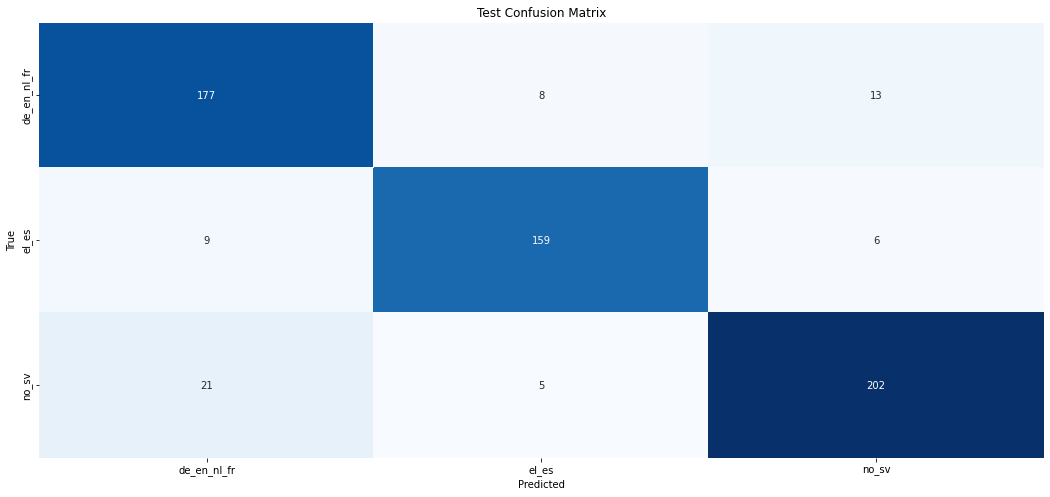

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sklearn

test_confu_matrix = confusion_matrix(y_test, predictions)
fault_type = ['de_en_nl_fr','el_es','no_sv']
plt.figure(1,figsize=(18,8))
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

sklearn.metrics.accuracy_score(predictions, y_test)